#### CSCE 670 :: Information Storage and Retrieval :: Texas A&M University :: Spring 2017


# Project: Different Faces of a City


Team members: ...

Project description here...

## Introduction

This project ...

The paper we are referring to...
* http://courses.cse.tamu.edu/caverlee/csce670_2013/livehoods-paper.pdf

We implemented **our algorithm** from scratch.

You can see the code below...



In [1]:
# Imports and global variables

import string
import glob, os
import re
import math
from collections import defaultdict
from math import radians, cos, sin, asin, sqrt

import operator
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image
from sklearn.cluster import SpectralClustering

AUSTIN_LAT_MIN = 30.097979
AUSTIN_LAT_MAX = 30.51
AUSTIN_LNG_MIN = -98.038402
AUSTIN_LNG_MAX = -97.555003
    
HOUSTON_LAT_MIN = 29.488986
HOUSTON_LAT_MAX = 30.139553
HOUSTON_LNG_MIN = -95.810704
HOUSTON_LNG_MAX = -95.022435

In [3]:
# Filter venue information to only include Austin and Houston venues
# Input: Filename of venue data
# Return: Venue information {venueid : {"lat" : latitude, "lng" : longitude}, ...}

    
def filter_venue(filename):
    ret = {}

    fp_austin = open("austin_venue.txt", 'a')
    fp_houston = open("houston_venue.txt", 'a')
    
    with open(filename, 'r') as fp:
        for line in fp:
            arr = re.split("\t", line)

            venueid = arr[0]
            lat = float(arr[1])
            lng = float(arr[2])

            venue_info = {}
            venue_info["lat"] = lat
            venue_info["lng"] = lng

            if (lat > AUSTIN_LAT_MIN and lat < AUSTIN_LAT_MAX) and (lng > AUSTIN_LNG_MIN and lng < AUSTIN_LNG_MAX):
                fp_austin.write(line)
                ret[venueid] = venue_info

            if (lat > HOUSTON_LAT_MIN and lat < HOUSTON_LAT_MAX) and (lng > HOUSTON_LNG_MIN and lng < HOUSTON_LNG_MAX):
                fp_houston.write(line)
                ret[venueid] = venue_info
            
    return ret
    
austin_houston_venue = filter_venue("dataset_TIST2015_POIs.txt")

In [5]:
# Filter checkin information to only include Austin and Houston checkins
# Input: filename of checkin data, venue information {venueid : {"lat" : latitude, "lng" : longitude}, ...}

def filter_checkin(filename, venue):
    fp_austin = open("austin_checkin.txt", 'a')
    fp_houston = open("houston_checkin.txt", 'a')
    
    with open(filename, 'r') as fp:
        for line in fp:
            arr = re.split("\t", line)

            venueid = arr[1]
            
            if not venue.has_key(venueid):
                continue
                
            venue_info = {}
            lat = venue[venueid]["lat"]
            lng = venue[venueid]["lng"]

            if (lat > AUSTIN_LAT_MIN and lat < AUSTIN_LAT_MAX) and (lng > AUSTIN_LNG_MIN and lng < AUSTIN_LNG_MAX):
                fp_austin.write(line)

            if (lat > HOUSTON_LAT_MIN and lat < HOUSTON_LAT_MAX) and (lng > HOUSTON_LNG_MIN and lng < HOUSTON_LNG_MAX):
                fp_houston.write(line)
             
filter_checkin("dataset_TIST2015_Checkins.txt", austin_houston_venue)

In [6]:
# Get venue's checkin information of given city data
# Input: Filename of checkin data
# Return: Venue's checkin information {venueid : [{userid : time}, {userid : time}, ...], ... }

def get_venue_checkin(filename):
    ret = {}
    
    fp = open(filename, 'r')
    lines = fp.readlines()
    
    for line in lines:
        checkin_time = {}
        arr = re.split("\t", line)
        
        userid = arr[0]
        venueid = arr[1]
        time = re.split(' ', arr[2])
        hour = time[3][0:2]
        
        checkin_time[userid] = hour

        if not ret.has_key(venueid):
            ret[venueid]=[checkin_time]
        else:
            ret[venueid].append(checkin_time)
            
    return ret

austin_venue_checkin = get_venue_checkin("austin_checkin.txt")
houston_venue_checkin = get_venue_checkin("houston_checkin.txt")

In [7]:
# Get venue information
# Input: Filename of checkin data
# Return: Venue information {venueid : {"latitiude" : latitude, "longitude" : longitude, "type" : type}, ...}

def get_venue_info(filename):
    ret = {}
    
    fp = open(filename, 'r')
    lines = fp.readlines()

    for line in lines:
        arr = re.split("\t", line)
        
        venue_info = {}
        
        venueid = arr[0]
        venue_info["latitude"] = arr[1]
        venue_info["longitude"] = arr[2]
        venue_info["type"] = arr[3]
        
        ret[venueid] = venue_info

    return ret

austin_venue = get_venue_info("austin_venue.txt")
houston_venue = get_venue_info("houston_venue.txt")

In [8]:
# Create hour histogram
# Input: Filename of checkin data, period in hours
# Return: [freq@0-period, freq@1-2*period, ...]

def create_histogram(filename, period):
    ret = {}
    
    fp = open(filename, 'r')
    lines = fp.readlines()

    for line in lines:
        arr = re.split('\t', line)
        
        time = re.split(' ', arr[2])
        hour = int(int(time[3][0:2])/period)
        
        if not ret.has_key(hour):
            ret[hour] = 1
        else:
            ret[hour] += 1
            
    sorted_keys = sorted(ret)
    
    ret_list = []
    
    for k in sorted_keys:
        ret_list.append((k, ret[k]))
            
    return ret_list

austin_histogram = create_histogram("austin_checkin.txt", 1)
houston_histogram = create_histogram("houston_checkin.txt", 1)

In [9]:
# Get checkin frequency of venues based on checkin time in hour
# Input: Filename of checkin data, period in hours
# Return: Checkin information {hour : {venueid : {userid : checkin_freq, ...}, ...}, ...}

def get_checkin_freq_by_hour(filename):
    ret = defaultdict(lambda : defaultdict(dict))
    
    fp = open(filename, 'r')
    lines = fp.readlines()

    for line in lines:
        arr = re.split('\t', line)
        
        userid = arr[0]
        venueid = arr[1]
        time = re.split(' ', arr[2])
        hour = int(time[3][0:2])
        if not ret.has_key(hour):
            ret[hour][venueid][userid] = 1
        else:
            if not ret[hour].has_key(venueid):
                ret[hour][venueid][userid] = 1
            else:
                if not ret[hour][venueid].has_key(userid):
                    ret[hour][venueid][userid] = 1
                else:
                    ret[hour][venueid][userid] += 1
                    
    return ret
    
austin_checkin_freq = get_checkin_freq_by_hour("austin_checkin.txt")
houston_checkin_freq = get_checkin_freq_by_hour("houston_checkin.txt")

In [10]:
# Create pie chart of venue types for each hour
# Input: Checkin information {hour : {venueid : {userid : checkin_freq, ...}, ...}, ...}, 
#        Venue information {venueid : {"latitiude" : latitude, "longitude" : longitude, "type" : type}, ...},
#        period in hours
# Return: pie chart {hour : {venue_type : freq, ...}, ...}

def create_pie_chart(freq, info):
    ret = {}
    
    for hour, venues in freq.iteritems():
        for venueid, users in venues.iteritems():
            venue_type = info[venueid]["type"]
            
            checkin_total = 0
            for userid, checkin_count in users.iteritems():
                checkin_total += checkin_count
                
            if not ret.has_key(hour):
                ret[hour] = {}
                ret[hour][venue_type] = checkin_total
                
            else:
                if not ret[hour].has_key(venue_type):
                    ret[hour][venue_type] = checkin_total
                else:
                    ret[hour][venue_type] += checkin_total
                    
    return ret

austin_pie_chart = create_pie_chart(austin_checkin_freq, austin_venue)
houston_pie_chart = create_pie_chart(houston_checkin_freq, houston_venue)

In [11]:
# Helper function for cosine similarity. Create a unit vector.
# Input: Vector for user checkin frequency {userid : freq, ...}
# Return: Unit vector for user checkin frequency {userid : normalized_freq, ...}

def normalized(vect):
    ret = {}
    
    total = 0
    
    for userid, freq in vect.iteritems():
        total += freq**2
    
    normalizer = math.sqrt(total)
    
    for userid, freq in vect.iteritems():
        ret[userid] = float(float(freq)/float(normalizer))
        
    return ret

In [12]:
# Compute the distance between two points using lat/long coordinate system
# Taken from Micheal Dunn from post http://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
# Input: Two points {"latitude": latitude, "longitude": longitude}
# Return: Distance between two points in float

def distance(v1, v2):
    lon1 = float(v1["longitude"])
    lat1 = float(v1["latitude"])
    lon2 = float(v2["longitude"])
    lat2 = float(v2["latitude"])

    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [24]:
# Compute 1000 nearest neigbors for later computation
# Input: filaname, venue information {venueid : {"latitiude" : latitude, "longitude" : longitude, "type" : type}, ...}
# Return: None
# Output: To file: venueid:1st_nearest_venueid,2nd_nearest_venueid,...

def preprocess_nearest_venues(filename, info):
    fp = open(filename, 'a')
    l = len(info)
    c = 0
    n = 1000
    for v1 in info.keys():
        if c % (l/100) == 0:
            print str(c*100.0/float(l))+"%"
        c += 1
        
        dist = []
        for v2 in info.keys():
            if v1 == v2:
                continue
                
            d = distance(info[v1], info[v2])
            dist.append((v2, d))
        dist.sort(key = lambda elem: elem[1])
        s = ""
        
        i = 0
        for e in dist:
            if i >= 1000:
                break
            s += e[0]+","
            i += 1
            
        fp.write(v1+":"+s[:-1]+"\n")
        
#preprocess_nearest_venues("nearest_neighbors_austin_1000.txt", austin_venue)
#preprocess_nearest_venues("nearest_neighbors_houston_1000.txt", houston_venue)

In [25]:
# Get the n nearest venues from precomputed nearest venue list file
# Input: filename, number of nearest venues
# Return: n nearest venues for each venue {venueid : [venueid, ...], ...}

def get_nearest_venues(filename, n):
    ret = {}

    fp = open(filename, 'r')
    lines = fp.readlines()

    for line in lines:
        arr = re.split(':', line)
        
        venueid = arr[0]
        nearest_list = re.split(',', arr[1])
        
        ret[venueid] = nearest_list[0:n]
             
    return ret

austin_nearest = get_nearest_venues("nearest_neighbors_austin_1000.txt", 20)
houston_nearest = get_nearest_venues("nearest_neighbors_houston_1000.txt", 20)

In [26]:
# Compute cosine similarity between two vectors
# Input: Two user checkin frequency vectors {userid : freq, ...}, {userid : freq, ...}
# Return: similarity score

def cosine_sim(vec1, vec2):
    ret = 0
    
    v1 = normalized(vec1)
    v2 = normalized(vec2)
    
    common_keys = list(set(v1.keys()) & set(v2.keys()))
    
    for k in common_keys:
        ret += v1[k]*v2[k]
    
    return ret

In [27]:
def all_day_checkin_freq(filename):
    ret = dict()
    
    for group in range(0,4):
        ret[group]=dict()

    for hours,values in filename.items():
        for venueid,id_value in values.items():
            for userid,count in id_value.items():
                    if not ret[0].has_key(venueid):
                        ret[0][venueid] = dict()
                        ret[0][venueid][userid] = count
                    else:
                        if not ret[0][venueid].has_key(userid):    
                            ret[0][venueid][userid] = count
                        else:
                            ret[0][venueid][userid] += count
    return ret

all_houston_checkin_freq = all_day_checkin_freq(houston_checkin_freq)
all_austin_checkin_freq = all_day_checkin_freq(austin_checkin_freq)
# print houston_checkin_freq_categorized[0]

In [28]:
def categorized_hoston_data(filename):
    ret = dict()
    for group in range(0,4):
        ret[group]=dict()
    #hours 0 and 23 go to group 0
    for hours,values in filename.items():
        for venueid,id_value in values.items():
            for userid,count in id_value.items():
                if hours== 0 or hours==23:
                    if not ret[0].has_key(venueid):
                        ret[0][venueid]=dict()
                        ret[0][venueid][userid] = count
                    else:
                        if not ret[0][venueid].has_key(userid):    
                            ret[0][venueid][userid] = count
                        else:
                            ret[0][venueid][userid] += count
                elif 1<= hours and hours <=9:
                    if not ret[1].has_key(venueid):
                        ret[1][venueid]=dict()
                        ret[1][venueid][userid] = count
                    else:
                        if not ret[1][venueid].has_key(userid):
                            ret[1][venueid][userid] = count
                        else:
                            ret[1][venueid][userid] += count
                elif 10<= hours and hours <=21:
                    if not ret[2].has_key(venueid):
                        ret[2][venueid]=dict()
                        ret[2][venueid][userid] = count
                    else:
                        if not ret[2][venueid].has_key(userid):
                            ret[2][venueid][userid] = count
                        else:
                            ret[2][venueid][userid] += count
                else:
                    if not ret[3].has_key(venueid):
                        ret[3][venueid]=dict()
                        ret[3][venueid][userid] = count
                    else:
                        if not ret[3][venueid].has_key(userid):
                            ret[3][venueid][userid] = count
                        else:
                            ret[3][venueid][userid] += count
    return ret

houston_checkin_freq_categorized = categorized_hoston_data(houston_checkin_freq)

In [29]:
def categorized_austin_data(filename):
    ret = dict()
    for group in range(0,4):
        ret[group]=dict()
    #hours 0 and 23 go to group 0
    for hours,values in filename.items():
        for venueid,id_value in values.items():
            for userid,count in id_value.items():
                if 0<= hours and hours <=7:
                    if not ret[0].has_key(venueid):
                        ret[0][venueid]=dict()
                        ret[0][venueid][userid] = count
                    else:
                        if not ret[0][venueid].has_key(userid):    
                            ret[0][venueid][userid] = count
                        else:
                            ret[0][venueid][userid] += count
                elif 8<= hours and hours <=9:
                    if not ret[1].has_key(venueid):
                        ret[1][venueid]=dict()
                        ret[1][venueid][userid] = count
                    else:
                        if not ret[1][venueid].has_key(userid):
                            ret[1][venueid][userid] = count
                        else:
                            ret[1][venueid][userid] += count
                elif 10<= hours and hours <=21:
                    if not ret[2].has_key(venueid):
                        ret[2][venueid]=dict()
                        ret[2][venueid][userid] = count
                    else:
                        if not ret[2][venueid].has_key(userid):
                            ret[2][venueid][userid] = count
                        else:
                            ret[2][venueid][userid] += count
                else:
                    if not ret[3].has_key(venueid):
                        ret[3][venueid]=dict()
                        ret[3][venueid][userid] = count
                    else:
                        if not ret[3][venueid].has_key(userid):
                            ret[3][venueid][userid] = count
                        else:
                            ret[3][venueid][userid] += count
    return ret

austin_checkin_freq_categorized = categorized_austin_data(austin_checkin_freq)

In [ ]:
# Input: {venueid : {userid : checkin_freq, ...}, ...},
#        {venueid : [venueid, ...], ...}
# Return: Nv x Nv Affinity Matrix; Nv = # venues
#         {venueid : {venueid : score, ...}, ...}

def create_affinity_matrix(venues, nearest):
    alpha = 0.1
    
    ret = {}
    
    #l = len(venues)
    #c = 0
    
    for v1 in venues.keys():
        ret[v1] = {}
        
        #if c % (l/100) == 0:
        #    print str(c*100.0/float(l))+"%"
        #c += 1

        for v2 in venues.keys():
            if v2 in nearest[v1] or v1 in nearest[v2]:
                ret[v1][v2] = cosine_sim(venues[v1], venues[v2]) + alpha
            else:
                ret[v1][v2] = 0
        
#         for v2 in nearest[v1]:
#             ret[v1][v2] = cosine_sim(venues[v1], venues[v2]) + alpha

    return ret

# houston_affinity = create_affinity_matrix(houston_checkin_freq_categorized[0], houston_nearest)
# houston_affinity = create_affinity_matrix(all_houston_checkin_freq[0], houston_nearest)
# austin_affinity = create_affinity_matrix(austin_checkin_freq_categorized[3], austin_nearest)
austin_affinity = create_affinity_matrix(all_austin_checkin_freq[0], austin_nearest)

In [13]:
# c = 0
# for k, v in austin_affinity.iteritems():
#    for kk, vv in v.iteritems():
#        if vv != 0.01:
#            c += 1
#            print vv
# print c
# print len(austin_affinity)*10
# print austin_affinity

# def get_nearest_venues_tmp(filename, n):
#    reader = open(filename+"_1000.txt", 'r')
#    writer = open(filename+".txt", 'w')
   
#    lines = reader.readlines()

#    for line in lines:
#        arr = re.split(':', line)
       
#        venueid = arr[0]
#        nearest_list = re.split(',', arr[1])
       
#        s = str(venueid) + ":"
       
#        for e in nearest_list[0:n]:
#            s += str(e) + ","
           
#        writer.write(s[:-1])

# get_nearest_venues_tmp("nearest_neighbors_austin", 100)
# get_nearest_venues_tmp("nearest_neighbors_houston", 100)

Here is a general version of Spectral clustering algorithm


0.0%
0.990099009901%
1.9801980198%
2.9702970297%
3.9603960396%
4.9504950495%
5.94059405941%
6.93069306931%
7.92079207921%
8.91089108911%
9.90099009901%
10.8910891089%
11.8811881188%
12.8712871287%
13.8613861386%
14.8514851485%
15.8415841584%
16.8316831683%
17.8217821782%
18.8118811881%
19.801980198%
20.7920792079%
21.7821782178%
22.7722772277%
23.7623762376%
24.7524752475%
25.7425742574%
26.7326732673%
27.7227722772%
28.7128712871%
29.702970297%
30.6930693069%
31.6831683168%
32.6732673267%
33.6633663366%
34.6534653465%
35.6435643564%
36.6336633663%
37.6237623762%
38.6138613861%
39.603960396%
40.5940594059%
41.5841584158%
42.5742574257%
43.5643564356%
44.5544554455%
45.5445544554%
46.5346534653%
47.5247524752%
48.5148514851%
49.504950495%
50.495049505%
51.4851485149%
52.4752475248%
53.4653465347%
54.4554455446%
55.4455445545%
56.4356435644%
57.4257425743%
58.4158415842%
59.4059405941%
60.396039604%
61.3861386139%
62.3762376238%
63.3663366337%
64.3564356436%
65.3465346535%
66.3366336634%

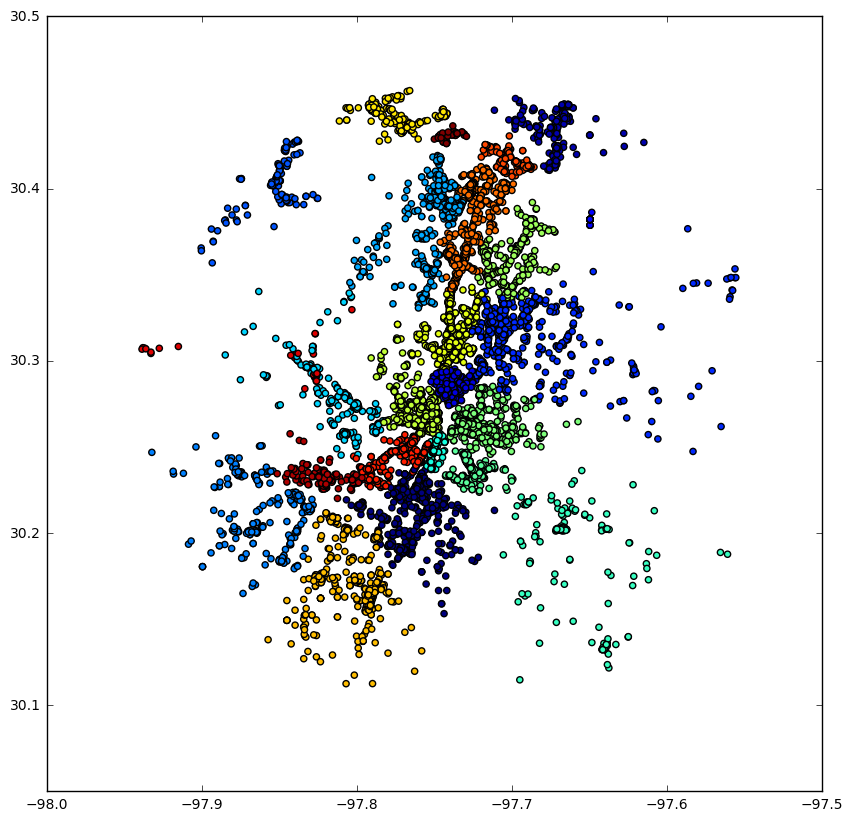

Clustering completed


In [79]:
# General version of Spectral clustering algorithm

def spectralClustering(venue, precomputed_affinity, theshold):

    affinity_matrix = []

    l = len(precomputed_affinity)
    c = 0

    for k in precomputed_affinity:

        if c % (l/100) == 0:
            print str(c*100.0/float(l))+"%"
        c += 1

        temp_matrix = []
        for k2 in precomputed_affinity[k]:
            temp_matrix.append(precomputed_affinity[k][k2])
        affinity_matrix.append(np.array(temp_matrix))

    affinity_matrix = np.array(affinity_matrix)

    print affinity_matrix.shape

    #labels = spectral_clustering(graph, n_clusters = 4, eigen_solver = 'arpack')
    sc = SpectralClustering(n_clusters = 25, n_jobs = -1, affinity = 'precomputed')
    sc.fit(affinity_matrix)

    labels = sc.labels_

    cluster = {}
    c = 0

    for v in precomputed_affinity:
        cluster[v] = labels[c]
        c += 1

    cluster_count = {}

    for v in venue:
        if v in precomputed_affinity:
            if cluster_count.get(cluster[v]) == None:
                cluster_count[cluster[v]] = 1
            else:
                cluster_count[cluster[v]] += 1

    max_index = max(cluster_count.iteritems(), key=operator.itemgetter(1))[0]

    x = []
    y = []
    t = []
    data = {}

    print "Total # of venues", len(precomputed_affinity)
    print "Noise cluster: ", max_index
    print "Cluster size: ", cluster_count[max_index]

    for v in venue:
        if v in precomputed_affinity:
             if float(venue[v]['longitude']) > theshold and cluster[v] != max_index:
                x.append(venue[v]['longitude'])
                y.append(venue[v]['latitude'])
                t.append(cluster[v])

                if data.get(cluster[v]) == None:
                    data.setdefault(cluster[v], [])
                temp = {}
                temp.setdefault('longitude', venue[v]['longitude'])
                temp.setdefault('latitude', venue[v]['latitude'])

                data[cluster[v]].append(temp)

    #          elif cluster[v] == max_index:
    #             print houston_venue[v]['type']

    x = np.array(x)
    y = np.array(y)
    t = np.array(t)

    plt.figure(figsize=(10, 10))
    plt.scatter(x, y, c = t)
    plt.show()

    out = []

    for k in data:
        out.append(data[k])

    with open('coords_list.json', 'w+') as json_file:
            json_data = json.dumps(out, indent = True)
            json_file.write(json_data)


    print "Clustering completed"
    
#spectralClustering(houston_venue, houston_affinity, -96.0)
spectralClustering(austin_venue, austin_affinity, -98.0)


Another **markdown cell** here!